# PHYSLITE columnar mjj analysis using coffea2023

<b>Package imports and versions</b>

In [1]:
from pathlib import Path
import warnings

import hist
import awkward as ak
import coffea
# import uproot
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
import dask_awkward as dak

In [2]:
print(f"coffea version: {coffea.__version__}")
print(f"awkward version: {ak.__version__}")
# print(f"uproot version: {uproot.__version__}")
print(f"hist version: {hist.__version__}")

coffea version: 2023.10.0rc1
awkward version: 2.5.1
hist version: 2.7.2


<b>Input PHYSLITE dataset</b>
- `mc20_13TeV.700320.Sh_2211_Zee_maxHTpTV2_BFilter.deriv.DAOD_PHYSLITE.e8351_s3681_r13167_p5855`
- 330 files / 497 GB / 35.6Mevts

In [3]:
local_input_path = "/data_ceph/kyungeon/PHYSLITE/"
dataset = "mc20_13TeV.700320.Sh_2211_Zee_maxHTpTV2_BFilter.deriv.DAOD_PHYSLITE.e8351_s3681_r13167_p5855"
# dataset = "mc20_13TeV.700320.Sh_2211_Zee_maxHTpTV2_BFilter.deriv.DAOD_PHYSLITE.e8351_s3681_r13167_p5631"
files = list(Path(local_input_path+dataset).glob("*root.1"))
print(f"Total #files = {len(files)}")

# files = files[:30]

Total #files = 330


In [4]:
len(files)

330

<b>Load dask awkward arrays with coffea PHYSLITEschema</b>

In [5]:
def get_events(files):
    factory = NanoEventsFactory.from_root(
        {fi:"CollectionTree" for fi in files},
        schemaclass=PHYSLITESchema,
        permit_dask=True
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        events = factory.events()
    
    return events

<b>Event selection</b>
- 2 jets

In [6]:
def event_selection(events):
    cut_2jet = ak.num(events.Jets, axis=1) == 2

    selections = cut_2jet
    
    return events[selections]

<b>Reconstruct mjj</b>

In [7]:
def reconstruct_mjj(events):
    jj_pair = ak.combinations(events.Jets, 2)
    j1, j2 = ak.unzip(jj_pair)
    jj_pair["p4"] = j1 + j2
    return jj_pair.p4

<b>Define histograms</b>

In [8]:
import hist.dask as dah

def get_histograms():
    return dah.Hist(
        dah.Hist.new.Reg(100, 0, 200_000, name="jj_mass", label=r"$m_{jj}$ [GeV]"),
        storage="weight"
    )

<b>Build analysis</b>

In [9]:
evts = get_events(files)

selected_evts = event_selection(evts)

jj_pair_p4 = reconstruct_mjj(selected_evts)

h = get_histograms()

output = h.fill(jj_mass=ak.flatten(jj_pair_p4.mass))
# output = h.fill(z_mass=ak.flatten(selected_evts.Electrons.pt))

Columns for the analysis

In [10]:
dak.necessary_columns(output)

{'from-uproot-a72460388cd40a2ea8992367fbb77bef': frozenset({'AnalysisJetsAuxDyn.eta',
            'AnalysisJetsAuxDyn.m',
            'AnalysisJetsAuxDyn.phi',
            'AnalysisJetsAuxDyn.pt'})}

dask task graph

In [11]:
output.visualize(optimize_graph=True)
# el_pair_p4.visualize(optimize_graph=True)

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

<b>Get results</b>

Set up local dask cluster

In [12]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=30, threads_per_worker=1)
client = Client(cluster)

In [13]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 30
Total threads: 30,Total memory: 62.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:23676,Workers: 30
Dashboard: http://127.0.0.1:8787/status,Total threads: 30
Started: Just now,Total memory: 62.54 GiB
Comm: tcp://127.0.0.1:13346,Total threads: 1
Dashboard: http://127.0.0.1:8708/status,Memory: 2.08 GiB
Nanny: tcp://127.0.0.1:8424,


Compute dask graphs

In [14]:
out_hist = output.compute()

<b>Plot histgorams</b>

In [17]:
import mplhep as mpl
import matplotlib.pyplot as plt
plt.style.use(mpl.style.ATLAS)

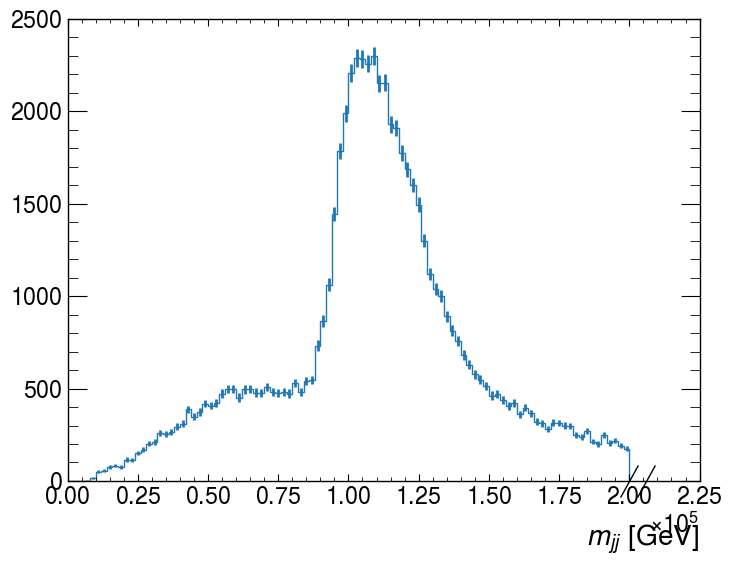

In [18]:
mpl.histplot(out_hist, edges=[0, 150_000]);

Shutdown dask cluster

In [20]:
client.close()
cluster.close()